In [212]:
# ====================================================
# 📘 Fraud Detection Feature Engineering Notebook
# ====================================================

# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Load Dataset ---
# Ensure your dataset (transactions_cleaned.csv) exists in the working directory
file_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\raw\fraud_detection_dataset_given.csv"
df = pd.read_csv(file_path)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (5000, 8)


,transaction_id,customer_id,kyc_verified,account_age_days,transaction_amount,channel,timestamp,is_fraud
0,TXN_200000,CUST_799,Yes,1050,256369,Mobile,2025-08-12 02:10:24,0
1,TXN_200001,CUST_484,Yes,295,6581,Mobile,2025-08-25 01:14:31,0
2,TXN_200002,CUST_791,Yes,2083,4492,Mobile,2025-08-17 12:12:40,0
3,TXN_200003,CUST_664,Yes,2789,275413,POS,2025-08-07 06:23:54,0
4,TXN_200004,CUST_157,Yes,694,98098,POS,2025-08-20 21:55:54,0


In [213]:
# --- Handle categorical text issues ---
df['kyc_verified'] = df['kyc_verified'].str.strip().str.title().replace({'Yes': 1, 'No': 0})

C:\Users\piyus\AppData\Local\Temp\ipykernel_7756\2346168859.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['kyc_verified'] = df['kyc_verified'].str.strip().str.title().replace({'Yes': 1, 'No': 0})


In [214]:
# ====================================================
# 🧩 Step 2: Feature Engineering from Timestamp
# ====================================================

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Extract time-based features
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['is_night_txn'] = df['hour_of_day'].apply(lambda x: 1 if 0 <= x <= 6 else 0)

# Drop timestamp if not needed in model
# df = df.drop(columns=['timestamp'])

# Check feature creation
df[['timestamp', 'hour_of_day', 'day_of_week', 'is_night_txn']].head()


,timestamp,hour_of_day,day_of_week,is_night_txn
0,2025-08-12 02:10:24,2,1,1
1,2025-08-25 01:14:31,1,0,1
2,2025-08-17 12:12:40,12,6,0
3,2025-08-07 06:23:54,6,3,1
4,2025-08-20 21:55:54,21,2,0


In [215]:
# ====================================================
# 🔠 Step 3: Encode Categorical Columns
# ====================================================

# Encode 'channel' using LabelEncoder
if 'channel' in df.columns:
    le = LabelEncoder()
    df['channel_encoded'] = le.fit_transform(df['channel'].astype(str))

# Drop original categorical column if not required
# df = df.drop(columns=['channel'])

print("Encoded channels:", list(le.classes_))
df[['channel', 'channel_encoded']].drop_duplicates().head()


Encoded channels: ['ATM', 'Mobile', 'POS', 'Web']


,channel,channel_encoded
0,Mobile,1
3,POS,2
6,ATM,0
7,Web,3


In [216]:
# Define threshold for high-value transactions
HIGH_AMOUNT_THRESHOLD = 50000  # 50k

# Create the new binary feature
df['is_high_amount_transaction'] = (df['transaction_amount'] > HIGH_AMOUNT_THRESHOLD).astype(int)

# Check results
df[['transaction_amount', 'is_high_amount_transaction']].head(10)


,transaction_amount,is_high_amount_transaction
0,256369,1
1,6581,0
2,4492,0
3,275413,1
4,98098,1
5,14744,0
6,5896,0
7,5276,0
8,16030,0
9,5294,0


In [217]:

# Define threshold for high transaction (you can adjust based on distribution)
high_amount_threshold = df['transaction_amount'].quantile(0.95)  # top 5% transactions

# 1️⃣ High amount AND night transaction
df['high_amount_night_txn'] = ((df['is_high_amount_transaction'] == 1) & 
                               (df['is_night_txn'] == 1)).astype(int)

# 2️⃣ New customer AND high amount
df['new_customer_high_amount'] = ((df['account_age_days'] < 180) & 
                                 (df['is_high_amount_transaction'] == 1)).astype(int)

# 3️⃣ KYC not verified AND low account age AND high transaction amount
df['kyc_low_age_txn'] = ((df['kyc_verified'] == 0) & 
                         (df['account_age_days'] < 365) & 
                         (df['transaction_amount'] > high_amount_threshold)).astype(int)

# Check result
print(df[['high_amount_night_txn', 'new_customer_high_amount', 'kyc_low_age_txn']].head())

# Optionally save the updated dataframe

   high_amount_night_txn  new_customer_high_amount  kyc_low_age_txn
0                      1                         0                0
1                      0                         0                0
2                      0                         0                0
3                      1                         0                0
4                      0                         0                0


In [218]:
df.head()


,transaction_id,customer_id,kyc_verified,account_age_days,transaction_amount,channel,timestamp,is_fraud,hour_of_day,day_of_week,is_night_txn,channel_encoded,is_high_amount_transaction,high_amount_night_txn,new_customer_high_amount,kyc_low_age_txn
0,TXN_200000,CUST_799,1,1050,256369,Mobile,2025-08-12 02:10:24,0,2,1,1,1,1,1,0,0
1,TXN_200001,CUST_484,1,295,6581,Mobile,2025-08-25 01:14:31,0,1,0,1,1,0,0,0,0
2,TXN_200002,CUST_791,1,2083,4492,Mobile,2025-08-17 12:12:40,0,12,6,0,1,0,0,0,0
3,TXN_200003,CUST_664,1,2789,275413,POS,2025-08-07 06:23:54,0,6,3,1,2,1,1,0,0
4,TXN_200004,CUST_157,1,694,98098,POS,2025-08-20 21:55:54,0,21,2,0,2,1,0,0,0


In [219]:
import pandas as pd

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ---------------------------
# 1️⃣ Derived features
# ---------------------------

# High amount night transaction
df['high_amount_night_txn'] = ((df['is_high_amount_transaction'] == 1) & 
                               (df['is_night_txn'] == 1)).astype(int)

# New customer high amount
df['new_customer_high_amount'] = ((df['account_age_days'] < 180) & 
                                  (df['is_high_amount_transaction'] == 1)).astype(int)

# KYC low age transaction (using mean as threshold or business-defined)
threshold = df['transaction_amount'].mean()
df['kyc_low_age_txn'] = ((df['kyc_verified'] == 0) & 
                         (df['account_age_days'] < 365) & 
                         (df['transaction_amount'] > threshold)).astype(int)

# Weekend transaction
df['is_weekend_txn'] = df['timestamp'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# ---------------------------
# 2️⃣ India Fixed Holidays
# ---------------------------
india_fixed_holidays = ['01-26', '08-15', '10-02', '12-25']  # month-day

# Generate holiday dates for all years in the data
holiday_dates = []
for year in df['timestamp'].dt.year.unique():
    for md in india_fixed_holidays:
        holiday_dates.append(pd.Timestamp(f"{year}-{md}"))

# Mark transactions on holidays
df['is_holiday_txn'] = df['timestamp'].dt.normalize().isin(holiday_dates).astype(int)

# ---------------------------
# 3️⃣ Final Feature Columns
# ---------------------------
feature_cols = [
    'customer_id', 'kyc_verified', 'account_age_days', 'transaction_amount',
    'channel_encoded', 'hour_of_day', 'day_of_week', 'is_night_txn',
    'is_high_amount_transaction', 'high_amount_night_txn',
    'new_customer_high_amount', 'kyc_low_age_txn',
    'is_weekend_txn', 'is_holiday_txn'
]

print(df[feature_cols].head())


  customer_id  kyc_verified  account_age_days  transaction_amount  \
0    CUST_799             1              1050              256369   
1    CUST_484             1               295                6581   
2    CUST_791             1              2083                4492   
3    CUST_664             1              2789              275413   
4    CUST_157             1               694               98098   

   channel_encoded  hour_of_day  day_of_week  is_night_txn  \
0                1            2            1             1   
1                1            1            0             1   
2                1           12            6             0   
3                2            6            3             1   
4                2           21            2             0   

   is_high_amount_transaction  high_amount_night_txn  \
0                           1                      1   
1                           0                      0   
2                           0               

In [220]:
df.nunique()

transaction_id                5000
customer_id                    698
kyc_verified                     2
account_age_days              2443
transaction_amount            4562
channel                          4
timestamp                     4993
is_fraud                         2
hour_of_day                     24
day_of_week                      7
is_night_txn                     2
channel_encoded                  4
is_high_amount_transaction       2
high_amount_night_txn            2
new_customer_high_amount         2
kyc_low_age_txn                  2
is_weekend_txn                   2
is_holiday_txn                   2
dtype: int64

In [221]:
# ====================================================
# 🧠 Step 4: Select Final Model Features
# ====================================================

feature_cols = [
    'customer_id',  # usually not used as a model feature
    'kyc_verified',
    'account_age_days',
    'transaction_amount',
    'channel_encoded',
    'hour_of_day',
    'day_of_week',
    'is_night_txn',
    'is_high_amount_transaction',
    'high_amount_night_txn',
    'new_customer_high_amount',
    'kyc_low_age_txn',
    'is_weekend_txn',
    'is_holiday_txn'
]

target_col = 'is_fraud'

# Filter only the required columns
df_model = df[feature_cols + [target_col]]

print("✅ Final feature set ready for modeling!")
df_model.head()


✅ Final feature set ready for modeling!


,customer_id,kyc_verified,account_age_days,transaction_amount,channel_encoded,hour_of_day,day_of_week,is_night_txn,is_high_amount_transaction,high_amount_night_txn,new_customer_high_amount,kyc_low_age_txn,is_weekend_txn,is_holiday_txn,is_fraud
0,CUST_799,1,1050,256369,1,2,1,1,1,1,0,0,0,0,0
1,CUST_484,1,295,6581,1,1,0,1,0,0,0,0,0,0,0
2,CUST_791,1,2083,4492,1,12,6,0,0,0,0,0,1,0,0
3,CUST_664,1,2789,275413,2,6,3,1,1,1,0,0,0,0,0
4,CUST_157,1,694,98098,2,21,2,0,1,0,0,0,0,0,0


In [222]:
# ====================================================
# 🔀 Step 5: Split Train/Test Datasets
# ====================================================

# Separate features and target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train/Test split completed.")
print("Train size:", X_train.shape, " Test size:", X_test.shape)


✅ Train/Test split completed.
Train size: (4000, 14)  Test size: (1000, 14)


In [223]:
# ====================================================
# 💾 Step 6: Save the Processed Datasets
# ====================================================

X_train.to_csv(r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv", index=False)
X_test.to_csv(r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv", index=False)
y_train.to_csv(r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv", index=False)
y_test.to_csv(r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv", index=False)

print("✅ Datasets saved successfully:")
print(" - train_features.csv")
print(" - test_features.csv")
print(" - train_labels.csv")
print(" - test_labels.csv")


✅ Datasets saved successfully:
 - train_features.csv
 - test_features.csv
 - train_labels.csv
 - test_labels.csv


In [224]:
# ====================================================
# 🔍 Step 7: Quick Verification
# ====================================================

print("\nSample of Train Features:")
display(X_train.head())

print("\nSample of Train Labels:")
display(y_train.head())



Sample of Train Features:


,customer_id,kyc_verified,account_age_days,transaction_amount,channel_encoded,hour_of_day,day_of_week,is_night_txn,is_high_amount_transaction,high_amount_night_txn,new_customer_high_amount,kyc_low_age_txn,is_weekend_txn,is_holiday_txn
1022,CUST_566,1,2348,7507,3,13,5,0,0,0,0,0,1,0
504,CUST_386,0,1861,228746,1,17,4,0,1,0,0,0,0,0
2456,CUST_187,1,1325,10559,3,3,1,1,0,0,0,0,0,0
3471,CUST_760,1,1564,61178,1,4,5,1,1,1,0,0,1,0
1595,CUST_554,1,1769,10300,0,14,5,0,0,0,0,0,1,0



Sample of Train Labels:


1022    0
504     0
2456    0
3471    0
1595    0
Name: is_fraud, dtype: int64

In [225]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 1022 to 710
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   customer_id                 4000 non-null   object
 1   kyc_verified                4000 non-null   int64 
 2   account_age_days            4000 non-null   int64 
 3   transaction_amount          4000 non-null   int64 
 4   channel_encoded             4000 non-null   int64 
 5   hour_of_day                 4000 non-null   int32 
 6   day_of_week                 4000 non-null   int32 
 7   is_night_txn                4000 non-null   int64 
 8   is_high_amount_transaction  4000 non-null   int64 
 9   high_amount_night_txn       4000 non-null   int64 
 10  new_customer_high_amount    4000 non-null   int64 
 11  kyc_low_age_txn             4000 non-null   int64 
 12  is_weekend_txn              4000 non-null   int64 
 13  is_holiday_txn              4000 non-null   int64 


In [226]:
X_train

,customer_id,kyc_verified,account_age_days,transaction_amount,channel_encoded,hour_of_day,day_of_week,is_night_txn,is_high_amount_transaction,high_amount_night_txn,new_customer_high_amount,kyc_low_age_txn,is_weekend_txn,is_holiday_txn
1022,CUST_566,1,2348,7507,3,13,5,0,0,0,0,0,1,0
504,CUST_386,0,1861,228746,1,17,4,0,1,0,0,0,0,0
2456,CUST_187,1,1325,10559,3,3,1,1,0,0,0,0,0,0
3471,CUST_760,1,1564,61178,1,4,5,1,1,1,0,0,1,0
1595,CUST_554,1,1769,10300,0,14,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,CUST_163,1,2404,5338,2,23,0,0,0,0,0,0,0,0
1407,CUST_352,1,2225,189137,1,21,2,0,1,0,0,0,0,0
488,CUST_205,1,447,41626,1,7,4,0,0,0,0,0,0,0
1296,CUST_227,0,1840,15009,1,8,5,0,0,0,0,0,1,0


In [227]:
# ===============================
# TensorFlow Keras Fraud Detection (Updated)
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
data_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
label_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"

df = pd.read_csv(data_path)
y = pd.read_csv(label_path).squeeze()

# -----------------------------
# 2️⃣ Feature Columns
# -----------------------------
feature_cols = [
    'kyc_verified',
    'account_age_days',
    'transaction_amount',
    'channel_encoded',
    'hour_of_day',
    'day_of_week',
    'is_night_txn',
    'is_high_amount_transaction',
    'high_amount_night_txn',
    'new_customer_high_amount',
    'kyc_low_age_txn',
    'is_weekend_txn',
    'is_holiday_txn'
]

X = df[feature_cols].copy()

# -----------------------------
# 3️⃣ Train-test split
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 4️⃣ Scale features
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
joblib.dump(scaler, "scaler.pkl")

# -----------------------------
# 5️⃣ Compute class weights
# -----------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# -----------------------------
# 6️⃣ Build Keras Model
# -----------------------------
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# -----------------------------
# 7️⃣ Train Model with Early Stopping
# -----------------------------
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)

# -----------------------------
# 8️⃣ Predict & Find Optimal Threshold
# -----------------------------
y_proba = model.predict(X_valid).flatten()

precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------------------
# 9️⃣ Model Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_valid, y_proba))

# -----------------------------
# 🔟 Save Model
# -----------------------------
model.save("keras_fraud_model_updated.keras")
print("\n✅ Model saved as 'keras_fraud_model_updated.keras'")


Class weights:

 {np.int64(0): np.float64(0.5473828258638386), np.int64(1): np.float64(5.776173285198556)}
Epoch 1/50


C:\Users\piyus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 - 2s - 47ms/step - auc: 0.6133 - loss: 0.6763 - val_auc: 0.7236 - val_loss: 0.7372
Epoch 2/50
50/50 - 0s - 6ms/step - auc: 0.7363 - loss: 0.6201 - val_auc: 0.6938 - val_loss: 0.6556
Epoch 3/50
50/50 - 0s - 7ms/step - auc: 0.7502 - loss: 0.5972 - val_auc: 0.7015 - val_loss: 0.6206
Epoch 4/50
50/50 - 0s - 7ms/step - auc: 0.7410 - loss: 0.6082 - val_auc: 0.7061 - val_loss: 0.6066
Epoch 5/50
50/50 - 0s - 7ms/step - auc: 0.7573 - loss: 0.5915 - val_auc: 0.7047 - val_loss: 0.5800
Epoch 6/50
50/50 - 0s - 6ms/step - auc: 0.7555 - loss: 0.5889 - val_auc: 0.7045 - val_loss: 0.5701
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimal F1 threshold: 0.55364126

=== 📊 MODEL EVALUATION ===
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.85       731
           1       0.21      0.68      0.32        69

    accuracy                           0.75       800
   macro avg       0.58      0.72      0.58       800
weighted avg       

In [1]:
# ===============================
# TensorFlow Keras Fraud Detection (Updated with Saved Train/Test)
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# -----------------------------
# 1️⃣ Load Preprocessed Train/Test Data
# -----------------------------
X_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
y_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
X_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv"
y_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv"

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path).squeeze()
X_valid = pd.read_csv(X_test_path)
y_valid = pd.read_csv(y_test_path).squeeze()
# Drop non-numeric identifier columns
X_train = X_train.drop(columns=['customer_id'], errors='ignore')
X_valid = X_valid.drop(columns=['customer_id'], errors='ignore')
# -----------------------------
# 2️⃣ Feature Columns
# -----------------------------
feature_cols = X_train.columns.tolist()  # already processed
X_train = X_train[feature_cols]
X_valid = X_valid[feature_cols]

# -----------------------------
# 3️⃣ Scale features
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
joblib.dump(scaler, "scaler.pkl")

# -----------------------------
# 4️⃣ Compute class weights
# -----------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# -----------------------------
# 5️⃣ Build Keras Model
# -----------------------------
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# -----------------------------
# 6️⃣ Train Model with Early Stopping
# -----------------------------
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)

# -----------------------------
# 7️⃣ Predict & Find Optimal Threshold
# -----------------------------
y_proba = model.predict(X_valid).flatten()

precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------------------
# 8️⃣ Model Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_valid, y_proba))

# -----------------------------
# 9️⃣ Save Model
# -----------------------------
model.save("keras_fraud_model_updated.keras")
print("\n✅ Model saved as 'keras_fraud_model_updated.keras'")


Class weights: {np.int64(0): np.float64(0.5473453749315819), np.int64(1): np.float64(5.780346820809249)}


C:\Users\piyus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
63/63 - 3s - 54ms/step - auc: 0.6683 - loss: 0.6557 - val_auc: 0.7828 - val_loss: 0.6186
Epoch 2/50
63/63 - 1s - 11ms/step - auc: 0.7192 - loss: 0.6264 - val_auc: 0.7968 - val_loss: 0.6054
Epoch 3/50
63/63 - 1s - 11ms/step - auc: 0.7343 - loss: 0.6079 - val_auc: 0.7993 - val_loss: 0.5922
Epoch 4/50
63/63 - 2s - 35ms/step - auc: 0.7406 - loss: 0.6010 - val_auc: 0.7978 - val_loss: 0.5779
Epoch 5/50
63/63 - 0s - 6ms/step - auc: 0.7549 - loss: 0.5878 - val_auc: 0.8010 - val_loss: 0.5803
Epoch 6/50
63/63 - 1s - 11ms/step - auc: 0.7580 - loss: 0.5887 - val_auc: 0.8055 - val_loss: 0.5691
Epoch 7/50
63/63 - 0s - 6ms/step - auc: 0.7626 - loss: 0.5815 - val_auc: 0.8066 - val_loss: 0.5681
Epoch 8/50
63/63 - 1s - 11ms/step - auc: 0.7678 - loss: 0.5782 - val_auc: 0.8063 - val_loss: 0.5720
Epoch 9/50
63/63 - 0s - 6ms/step - auc: 0.7548 - loss: 0.5901 - val_auc: 0.8058 - val_loss: 0.5682
Epoch 10/50
63/63 - 1s - 11ms/step - auc: 0.7541 - loss: 0.5912 - val_auc: 0.8045 - val_loss: 0.5340
Ep

In [4]:
# ===============================
# TensorFlow Keras Fraud Detection (Future-Proof)
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import json

# -----------------------------
# 1️⃣ Load Preprocessed Train/Test Data
# -----------------------------
X_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
y_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
X_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv"
y_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv"

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path).squeeze()
X_valid = pd.read_csv(X_test_path)
y_valid = pd.read_csv(y_test_path).squeeze()

# Drop non-numeric identifier columns
X_train = X_train.drop(columns=['customer_id'], errors='ignore')
X_valid = X_valid.drop(columns=['customer_id'], errors='ignore')

# -----------------------------
# 2️⃣ Feature Columns
# -----------------------------
feature_cols = X_train.columns.tolist()
X_train = X_train[feature_cols]
X_valid = X_valid[feature_cols]

# Save feature columns for later
with open("feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

# -----------------------------
# 3️⃣ Scale features
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Save scaler for later use
joblib.dump(scaler, "scaler.pkl")

# -----------------------------
# 4️⃣ Compute class weights
# -----------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# -----------------------------
# 5️⃣ Build Keras Model
# -----------------------------
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# -----------------------------
# 6️⃣ Train Model with Early Stopping
# -----------------------------
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)

# -----------------------------
# 7️⃣ Predict & Find Optimal Threshold
# -----------------------------
y_proba = model.predict(X_valid).flatten()

precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------------------
# 8️⃣ Model Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_valid, y_proba))

# -----------------------------
# 9️⃣ Save Model (TF SavedModel format)
# -----------------------------
model.save("keras_fraud_model_updated_tf", save_format="tf")  # folder format
print("\n✅ Model saved as 'keras_fraud_model_updated_tf/' folder")

# -----------------------------
# 1️⃣0️⃣ Optional: Prediction Wrapper
# -----------------------------
def predict_model(X, threshold=best_threshold):
    """
    Returns predictions and probabilities for given data
    """
    proba = model.predict(X).flatten()
    pred = (proba >= threshold).astype(int)
    return pred, proba


Class weights: {np.int64(0): np.float64(0.5473453749315819), np.int64(1): np.float64(5.780346820809249)}


C:\Users\piyus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
63/63 - 3s - 47ms/step - auc: 0.6100 - loss: 0.6920 - val_auc: 0.7610 - val_loss: 0.6241
Epoch 2/50
63/63 - 0s - 6ms/step - auc: 0.7150 - loss: 0.6250 - val_auc: 0.7934 - val_loss: 0.6003
Epoch 3/50
63/63 - 0s - 5ms/step - auc: 0.7461 - loss: 0.6013 - val_auc: 0.8017 - val_loss: 0.5341
Epoch 4/50
63/63 - 0s - 5ms/step - auc: 0.7373 - loss: 0.6053 - val_auc: 0.8002 - val_loss: 0.5540
Epoch 5/50
63/63 - 0s - 5ms/step - auc: 0.7450 - loss: 0.5971 - val_auc: 0.8036 - val_loss: 0.5500
Epoch 6/50
63/63 - 0s - 5ms/step - auc: 0.7475 - loss: 0.5954 - val_auc: 0.7996 - val_loss: 0.5478
Epoch 7/50
63/63 - 0s - 5ms/step - auc: 0.7529 - loss: 0.5896 - val_auc: 0.8021 - val_loss: 0.5336
Epoch 8/50
63/63 - 0s - 5ms/step - auc: 0.7486 - loss: 0.5951 - val_auc: 0.8024 - val_loss: 0.5512
Epoch 9/50
63/63 - 0s - 5ms/step - auc: 0.7566 - loss: 0.5903 - val_auc: 0.8014 - val_loss: 0.5575
Epoch 10/50
63/63 - 0s - 5ms/step - auc: 0.7561 - loss: 0.5854 - val_auc: 0.7987 - val_loss: 0.5058
32/32 ━━

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [5]:
# ===============================
# PyTorch Fraud Detection
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
X_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
y_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
X_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv"
y_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv"

X_train = pd.read_csv(X_train_path).drop(columns=['customer_id'], errors='ignore')
y_train = pd.read_csv(y_train_path).squeeze()
X_valid = pd.read_csv(X_test_path).drop(columns=['customer_id'], errors='ignore')
y_valid = pd.read_csv(y_test_path).squeeze()

feature_cols = X_train.columns.tolist()
X_train = X_train[feature_cols]
X_valid = X_valid[feature_cols]

# -----------------------------
# 2️⃣ Scale features
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
joblib.dump(scaler, "scaler_pytorch.pkl")

# -----------------------------
# 3️⃣ Convert to PyTorch tensors
# -----------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# -----------------------------
# 4️⃣ Compute class weights
# -----------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# -----------------------------
# 5️⃣ Define Model
# -----------------------------
class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super(FraudNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudNet(X_train.shape[1]).to(device)

criterion = nn.BCELoss(weight=None)  # We'll apply class weights manually in loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 6️⃣ Training loop with early stopping
# -----------------------------
patience = 5
best_auc = 0
counter = 0

for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        
        outputs = model(xb)
        # Apply class weights manually
        weights = yb * class_weights_tensor[1] + (1 - yb) * class_weights_tensor[0]
        loss = criterion(outputs, yb)
        loss = (loss * weights).mean()
        
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    y_true = []
    y_probs = []
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            probs = model(xb)
            y_probs.extend(probs.cpu().numpy())
            y_true.extend(yb.cpu().numpy())
    
    val_auc = roc_auc_score(y_true, y_probs)
    print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}")
    
    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_fraud_model_pytorch.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# -----------------------------
# 7️⃣ Find Optimal Threshold
# -----------------------------
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (np.array(y_probs) >= best_threshold).astype(int)

# -----------------------------
# 8️⃣ Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_true, y_probs))


Epoch 1: Val AUC = 0.6475
Epoch 2: Val AUC = 0.7779
Epoch 3: Val AUC = 0.7942
Epoch 4: Val AUC = 0.7953
Epoch 5: Val AUC = 0.7968
Epoch 6: Val AUC = 0.7988
Epoch 7: Val AUC = 0.7965
Epoch 8: Val AUC = 0.7995
Epoch 9: Val AUC = 0.7993
Epoch 10: Val AUC = 0.7986
Epoch 11: Val AUC = 0.7974
Epoch 12: Val AUC = 0.7983
Epoch 13: Val AUC = 0.7982
Early stopping triggered.
Optimal F1 threshold: 0.10288863

=== 📊 MODEL EVALUATION ===
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.75      0.85       914
         1.0       0.24      0.83      0.37        86

    accuracy                           0.76      1000
   macro avg       0.61      0.79      0.61      1000
weighted avg       0.92      0.76      0.81      1000

Confusion Matrix:
 [[689 225]
 [ 15  71]]
ROC-AUC Score: 0.798190931759198


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

def predict_fraud_from_raw_timestamp(df: pd.DataFrame,
                                     model_path="keras_fraud_model_updated.keras",
                                     scaler_path="scaler.pkl",
                                     threshold=0.5536,
                                     high_amount_threshold=10000):
    """
    Predict fraud using raw features including a timestamp column.
    Derived features are computed automatically from timestamp and other raw features.
    
    Args:
        df (pd.DataFrame): Must include columns:
            customer_id, kyc_verified, account_age_days, transaction_amount,
            channel_encoded, timestamp
        model_path (str): Path to saved Keras model
        scaler_path (str): Path to saved StandardScaler
        threshold (float): Threshold for classification
        high_amount_threshold (float): Transaction amount above which considered high

    Returns:
        pd.DataFrame: customer_id, predicted_label, fraud_risk_score
    """
    # -----------------------------
    # 1️⃣ Load model & scaler
    # -----------------------------
    model = tf.keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)

    # -----------------------------
    # 2️⃣ Extract customer_id
    # -----------------------------
    customer_ids = df['customer_id'].values
    df_raw = df.copy()

    # -----------------------------
    # 3️⃣ Extract hour and day from timestamp
    # -----------------------------
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
    df_raw['hour_of_day'] = df_raw['timestamp'].dt.hour
    df_raw['day_of_week'] = df_raw['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

    # -----------------------------
    # 4️⃣ Derive engineered features
    # -----------------------------
    df_raw['is_night_txn'] = df_raw['hour_of_day'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)
    df_raw['is_high_amount_transaction'] = df_raw['transaction_amount'].apply(lambda x: 1 if x > high_amount_threshold else 0)
    df_raw['high_amount_night_txn'] = ((df_raw['is_high_amount_transaction'] == 1) & (df_raw['is_night_txn'] == 1)).astype(int)
    df_raw['new_customer_high_amount'] = ((df_raw['account_age_days'] < 30) & (df_raw['transaction_amount'] > high_amount_threshold)).astype(int)
    df_raw['kyc_low_age_txn'] = ((df_raw['kyc_verified'] == 0) & (df_raw['account_age_days'] < 30)).astype(int)
    df_raw['is_weekend_txn'] = df_raw['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)
    df_raw['is_holiday_txn'] = 0  # can be updated externally if holiday calendar available

    # -----------------------------
    # 5️⃣ Select features in correct order
    # -----------------------------
    feature_cols = [
        'kyc_verified', 'account_age_days', 'transaction_amount', 'channel_encoded',
        'hour_of_day', 'day_of_week', 'is_night_txn', 'is_high_amount_transaction',
        'high_amount_night_txn', 'new_customer_high_amount', 'kyc_low_age_txn',
        'is_weekend_txn', 'is_holiday_txn'
    ]
    X = df_raw[feature_cols]

    # -----------------------------
    # 6️⃣ Scale features
    # -----------------------------
    X_scaled = scaler.transform(X)

    # -----------------------------
    # 7️⃣ Predict probabilities and labels
    # -----------------------------
    y_proba = model.predict(X_scaled).flatten()
    y_pred = (y_proba >= threshold).astype(int)

    # -----------------------------
    # 8️⃣ Return results
    # -----------------------------
    results = pd.DataFrame({
        'customer_id': customer_ids,
        'predicted_label': y_pred,
        'fraud_risk_score': y_proba
    })

    return results

# -----------------------------
# Example usage:
# new_data = pd.read_csv("new_transactions_with_timestamp.csv")
# predictions = predict_fraud_from_raw_timestamp(new_data)
# print(predictions.head())
import pandas as pd
from datetime import datetime

# -----------------------------
# 1️⃣ Create dummy input DataFrame
# -----------------------------
dummy_data = pd.DataFrame({
    'customer_id': ['CUST001', 'CUST002', 'CUST003'],
    'kyc_verified': [1, 0, 1],
    'account_age_days': [120, 5, 45],
    'transaction_amount': [5000, 20000, 15000],
    'channel_encoded': [0, 1, 2],  # e.g., 0=online, 1=ATM, 2=branch
    'timestamp': [
        '2025-10-23 14:35:00',
        '2025-10-24 02:10:00',
        '2025-10-25 20:45:00'
    ]
})

# -----------------------------
# 2️⃣ Import the prediction function
# Make sure the function `predict_fraud_from_raw_timestamp` is defined or imported
# -----------------------------
# from your_module import predict_fraud_from_raw_timestamp

# -----------------------------
# 3️⃣ Call function to predict
# -----------------------------
predictions = predict_fraud_from_raw_timestamp(dummy_data)

# -----------------------------
# 4️⃣ Show results
# -----------------------------
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
  customer_id  predicted_label  fraud_risk_score
0     CUST001                0          0.335568
1     CUST002                1          0.747147
2     CUST003                0          0.518445


In [3]:
import tensorflow as tf
print(tf.__version__)         # Should be 2.20.x
print(tf.keras.__version__)   # Should be compatible with TF 2.20


2.20.0
3.11.3


In [229]:
# ===============================
# 🐱 CatBoost Fraud Detection
# ===============================

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
X_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
y_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
X_test_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv"
y_test_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv"

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path).squeeze()
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()

# -----------------------------
# 2️⃣ Drop customer_id column if exists
# -----------------------------
for df in [X_train, X_test]:
    if 'customer_id' in df.columns:
        df.drop('customer_id', axis=1, inplace=True)

# -----------------------------
# 3️⃣ Define categorical features
# -----------------------------
cat_features = ['kyc_verified', 'channel_encoded', 'hour_of_day', 'day_of_week',
                'is_night_txn', 'is_high_amount_transaction', 'high_amount_night_txn',
                'new_customer_high_amount', 'kyc_low_age_txn', 'is_weekend_txn', 'is_holiday_txn']

# Keep only columns present in the dataset
cat_features = [c for c in cat_features if c in X_train.columns]

# -----------------------------
# 4️⃣ Initialize CatBoostClassifier
# -----------------------------
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    loss_function='Logloss',
    random_seed=42,
    verbose=100,
    class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)]  # handle imbalance
)

# -----------------------------
# 5️⃣ Train Model
# -----------------------------
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=100)

# -----------------------------
# 6️⃣ Predict & Find Optimal F1 Threshold
# -----------------------------
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------------------
# 7️⃣ Model Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# -----------------------------
# 8️⃣ Save Model
# -----------------------------
model.save_model("catboost_fraud_model.cbm")
print("\n✅ Model saved as 'catboost_fraud_model.cbm'")



0:	test: 0.7805710	best: 0.7805710 (0)	total: 41ms	remaining: 41s
100:	test: 0.7960664	best: 0.8013714 (69)	total: 4.26s	remaining: 37.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8013714315
bestIteration = 69

Shrink model to first 70 iterations.
Optimal F1 threshold: 0.583867455123639

=== 📊 MODEL EVALUATION ===
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86       914
           1       0.24      0.81      0.38        86

    accuracy                           0.77      1000
   macro avg       0.61      0.79      0.62      1000
weighted avg       0.91      0.77      0.82      1000

Confusion Matrix:
 [[697 217]
 [ 16  70]]
ROC-AUC Score: 0.8013714314793141

✅ Model saved as 'catboost_fraud_model.cbm'


In [3]:
# ============================================
# 🟢 CatBoost Fraud Detection (Balanced Mode)
# ============================================

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
X_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_features.csv"
y_train_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
X_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_features.csv"
y_test_path  = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\test_data\test_labels.csv"

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path).squeeze()
X_test  = pd.read_csv(X_test_path)
y_test  = pd.read_csv(y_test_path).squeeze()

# Drop customer ID column if present
if 'customer_id' in X_train.columns:
    X_train = X_train.drop(columns=['customer_id'])
    X_test  = X_test.drop(columns=['customer_id'])

# -----------------------------
# 2️⃣ Define feature columns
# -----------------------------
feature_cols = [
    'kyc_verified',
    'account_age_days',
    'transaction_amount',
    'channel_encoded',
    'hour_of_day',
    'day_of_week',
    'is_night_txn',
    'is_high_amount_transaction',
    'high_amount_night_txn',
    'new_customer_high_amount',
    'kyc_low_age_txn',
    'is_weekend_txn',
    'is_holiday_txn'
]

X_train = X_train[feature_cols]
X_test  = X_test[feature_cols]

# -----------------------------
# 3️⃣ Compute class weights
# -----------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_list = class_weights.tolist()
print("Class weights:", class_weights_list)

# -----------------------------
# 4️⃣ Create CatBoost Pool
# -----------------------------
train_pool = Pool(data=X_train, label=y_train)
test_pool  = Pool(data=X_test, label=y_test)

# -----------------------------
# 5️⃣ Initialize CatBoost (Balanced)
# -----------------------------
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=50,
    class_weights=class_weights_list  # ⚡ Balanced mode via numeric weights
)

# -----------------------------
# 6️⃣ Train Model
# -----------------------------
cat_model.fit(train_pool, eval_set=test_pool)

# -----------------------------
# 7️⃣ Predict & Find Optimal F1 Threshold
# -----------------------------
y_proba = cat_model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Optimal F1 threshold:", best_threshold)

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------------------
# 8️⃣ Model Evaluation
# -----------------------------
print("\n=== 📊 MODEL EVALUATION ===")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# -----------------------------
# 9️⃣ Save Model
# -----------------------------
cat_model.save_model("catboost_fraud_model_balanced_tuned.cbm")
print("\n✅ Model saved as 'catboost_fraud_model_balanced_tuned.cbm'")


Class weights: [0.5473453749315819, 5.780346820809249]
0:	test: 0.7889230	best: 0.7889230 (0)	total: 2.5ms	remaining: 2.5s
50:	test: 0.7904560	best: 0.7998130 (19)	total: 117ms	remaining: 2.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7998129866
bestIteration = 19

Shrink model to first 20 iterations.
Optimal F1 threshold: 0.5162514391546276

=== 📊 MODEL EVALUATION ===
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85       914
           1       0.24      0.83      0.37        86

    accuracy                           0.76      1000
   macro avg       0.61      0.79      0.61      1000
weighted avg       0.92      0.76      0.81      1000

Confusion Matrix:
 [[690 224]
 [ 15  71]]
ROC-AUC Score: 0.7998129866164571

✅ Model saved as 'catboost_fraud_model_balanced_tuned.cbm'


In [1]:
import pandas as pd
from datetime import datetime
from catboost import CatBoostClassifier

# =========================================
# 🔍 Load trained CatBoost model
# =========================================
model_path = "catboost_fraud_model_balanced_tuned.cbm"
cat_model = CatBoostClassifier()
cat_model.load_model(model_path)

# =========================================
# 🧠 Feature Derivation (Aligned with Training)
# =========================================
def derive_features_auto(input_data: dict) -> pd.DataFrame:
    """
    Derives all 13 features from minimal numeric + datetime inputs.

    Expected inputs:
    {
        'kyc_verified': 0 or 1,
        'account_age_days': int,
        'transaction_amount': float,
        'channel_encoded': int,
        'transaction_datetime': 'YYYY-MM-DD HH:MM:SS',
        'is_holiday': 0 or 1
    }
    """

    txn_dt = datetime.strptime(input_data['transaction_datetime'], "%Y-%m-%d %H:%M:%S")

    hour_of_day = txn_dt.hour
    day_of_week = txn_dt.weekday()
    is_night_txn = 1 if hour_of_day >= 22 or hour_of_day < 6 else 0
    is_weekend_txn = 1 if day_of_week >= 5 else 0

    is_high_amount_transaction = 1 if input_data['transaction_amount'] > 50000 else 0
    high_amount_night_txn = 1 if is_high_amount_transaction and is_night_txn else 0

    # 🚀 Derive "new_customer_high_amount" automatically
    is_new_customer = 1 if input_data['account_age_days'] < 30 else 0
    new_customer_high_amount = 1 if is_new_customer and is_high_amount_transaction else 0

    kyc_low_age_txn = 1 if (input_data['kyc_verified'] == 0 and input_data['account_age_days'] < 30) else 0

    feature_dict = {
        'kyc_verified': input_data['kyc_verified'],
        'account_age_days': input_data['account_age_days'],
        'transaction_amount': input_data['transaction_amount'],
        'channel_encoded': input_data['channel_encoded'],
        'hour_of_day': hour_of_day,
        'day_of_week': day_of_week,
        'is_night_txn': is_night_txn,
        'is_high_amount_transaction': is_high_amount_transaction,
        'high_amount_night_txn': high_amount_night_txn,
        'new_customer_high_amount': new_customer_high_amount,
        'kyc_low_age_txn': kyc_low_age_txn,
        'is_weekend_txn': is_weekend_txn,
        'is_holiday_txn': input_data['is_holiday']
    }

    return pd.DataFrame([feature_dict])

# =========================================
# 🚀 Fraud Prediction Function
# =========================================
def predict_fraud(input_data: dict, threshold: float = 0.5):
    """
    Predicts fraud risk using trained CatBoost model.
    Returns binary flag and risk probability.
    """
    features_df = derive_features_auto(input_data)
    proba = cat_model.predict_proba(features_df)[0, 1]
    is_fraud = int(proba >= threshold)

    return {
        "is_fraud": is_fraud,
        "risk_score": round(proba, 4),
        "derived_features": features_df.to_dict(orient='records')[0]
    }

# =========================================
# 🧪 Example Usage
# =========================================
if __name__ == "__main__":
    example_input = {
        "kyc_verified": 1,
        "account_age_days": 12,
        "transaction_amount": 85000,
        "channel_encoded": 0,  # already encoded numeric value
        "transaction_datetime": "2025-11-01 23:45:00",
        "is_holiday": 0
    }

    result = predict_fraud(example_input)
    print(result)


{'is_fraud': 0, 'risk_score': np.float64(0.4784), 'derived_features': {'kyc_verified': 1, 'account_age_days': 12, 'transaction_amount': 85000, 'channel_encoded': 0, 'hour_of_day': 23, 'day_of_week': 5, 'is_night_txn': 1, 'is_high_amount_transaction': 1, 'high_amount_night_txn': 1, 'new_customer_high_amount': 1, 'kyc_low_age_txn': 0, 'is_weekend_txn': 1, 'is_holiday_txn': 0}}


Class Distribution:
is_fraud
0    3654
1     346
Name: count, dtype: int64

Class Proportions:
is_fraud
0    0.9135
1    0.0865
Name: proportion, dtype: float64


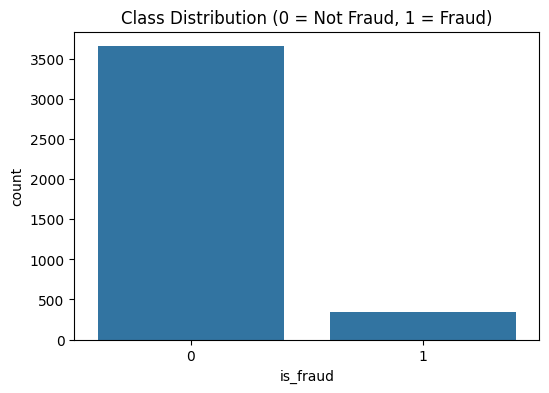

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load labels
labels_path = r"D:\projects\BFSI_Predictive_modelling\bfsi_v4\data\processed\train_data\train_labels.csv"
y_train = pd.read_csv(labels_path).squeeze()  # .squeeze() makes it a Series

# 1️⃣ Check counts
class_counts = y_train.value_counts()
print("Class Distribution:")
print(class_counts)

# 2️⃣ Check proportions
class_props = y_train.value_counts(normalize=True)
print("\nClass Proportions:")
print(class_props)

# 3️⃣ Visualize
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution (0 = Not Fraud, 1 = Fraud)")
plt.show()
